In [1]:
%pip install darts
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_absolute_error
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import optuna
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple




In [ ]:
# ## Read data
# data = pd.read_parquet(r"..\01_Datenaufbereitung\Output\Calculated\df_15.parquet")
# data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
# data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 'Temperature[°C]', 'SOH_ZHU']]

# ## Resample to hourly
# data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
# data_hourly = data.resample('h').mean().reset_index()

# ## Fill missing values
# data_hourly.interpolate(method='linear', inplace=True)
# data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)

Processing cells: 100%|██████████| 15/15 [01:14<00:00,  4.98s/cell]


In [ ]:
# ## Read data
# data = pd.read_parquet(r"..\01_Datenaufbereitung\Output\Calculated\df_15.parquet")
# data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
# data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 'Temperature[°C]', 'SOH_ZHU']]

# ## Resample to hourly
# data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
# data_hourly = data.resample('h').mean().reset_index()

# ## Fill missing values
# data_hourly.interpolate(method='linear', inplace=True)
# data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)

Processing cells: 100%|██████████| 15/15 [01:14<00:00,  4.98s/cell]


Text(0.5, 0, 'Time')

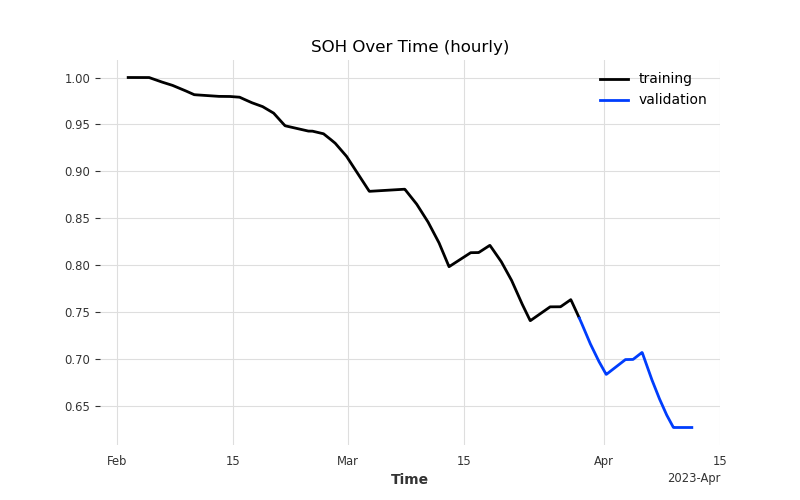

In [ ]:
# # ## Data to time series
# # target_series = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
# # covariates = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])

# # ## Time align
# # target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)

# # ## Covariates normalization
# # scaler = Scaler() # Scale data [min,max] to [0,1]
# # ## Don't scale SOH
# # covariates_scaled = scaler.fit_transform(covariates)

# ## Data split
# train_series, val_series = target_series.split_after(0.8)
# cov_train, cov_val = covariates_scaled.split_after(0.8)

# # Time align
# required_start_time = train_series.start_time() - pd.Timedelta(hours=12) 
# if cov_train.start_time() > required_start_time:
#     cov_train = covariates_scaled.slice(required_start_time, cov_train.end_time())
# if cov_val.start_time() > required_start_time:
#     cov_val = covariates_scaled.slice(required_start_time, cov_val.end_time())

# plt.figure(figsize=(8, 5))
# train_series.plot(label="training")
# val_series.plot(label="validation")
# plt.title("SOH Over Time (hourly)")
# plt.xlabel("Time")

In [3]:
def load_data(data_dir: str, feature_range=(-1, 1)) -> dict:
    data_path = Path(data_dir)
    processed_data = {}

    # Find all parquet files
    parquet_files = list(data_path.glob("**/df*.parquet"))
    print(f"Found {len(parquet_files)} parquet files")

    for file_path in tqdm(parquet_files, desc="Processing cells", unit="cell"):
        # Extract cell number from parent directory name
        file_name = file_path.stem  
        cell_number = file_name.replace('df_', '')  
        cell_name = f'C{cell_number}'  
        tqdm.write(f"Processing {cell_name} ...")
            
        # Load and process data
        data = pd.read_parquet(file_path)
        data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        
        # Select relevant columns
        data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 
                    'Temperature[°C]', 'SOH_ZHU']]
        
        # Resample to hourly
        data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
        data_hourly = data.resample('h').mean().reset_index()
        
        # Fill missing values
        data_hourly.interpolate(method='linear', inplace=True)
        data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
        
        # Convert to time series
        target_series = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU'
        )
        covariates = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 
            ['Current[A]', 'Voltage[V]', 'Temperature[°C]']
        )
        
        # Time align
        target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)
        
        # Scale covariates
        scaler = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
        covariates_scaled = scaler.fit_transform(covariates)
        
        processed_data[cell_name] = {
            'target': target_series,
            'covariates_scaled': covariates_scaled
        }
    
    return processed_data

data_dir = "../01_Datenaufbereitung/Output/Calculated/"
processed_data = load_data(data_dir)

Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:15<03:40, 15.78s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:22<02:15, 10.43s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:29<01:43,  8.66s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:34<01:22,  7.53s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:38<01:00,  6.01s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:41<00:46,  5.21s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:43<00:31,  3.98s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:45<00:23,  3.31s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:50<00:24,  4.10s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [00:56<00:23,  4.61s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:02<00:19,  4.99s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:09<00:16,  5.46s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:14<00:10,  5.34s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:20<00:05,  5.66s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:24<00:00,  5.62s/cell]


In [4]:
def inspect_data_ranges(data_dict: dict):
   """
   Inspect time ranges and value ranges for each battery in the data dictionary
   """
   for cell_name, cell_data in data_dict.items():
       print(f"\n=== {cell_name} ===")
       
       # Get target data range
       target = cell_data['target']
       target_values = target.values().flatten()  # Flatten array for calculation
       print("\nTarget (SOH_ZHU):")
       print(f"Time Range: {target.start_time()} to {target.end_time()}")
       print(f"Value Range: {target_values.min():.4f} to {target_values.max():.4f}")
       print(f"Number of Data Points: {len(target)}")
       
       # Get covariates data range
       covariates = cell_data['covariates_scaled']
       cov_values = covariates.values()
       print("\nCovariates (scaled):")
       for i, feature in enumerate(covariates.components):
           values = cov_values[:, i].flatten()
           print(f"{feature}:")
           print(f"Value Range: {values.min():.4f} to {values.max():.4f}")

# View all data ranges
print("All Data Ranges:")
inspect_data_ranges(processed_data)

All Data Ranges:

=== C01 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-09-16 07:00:00
Value Range: 0.9225 to 1.0000
Number of Data Points: 5423

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C05 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 12:00:00
Value Range: 0.9172 to 1.0000
Number of Data Points: 4612

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C07 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 14

In [9]:
def split_cell_data(processed_data: dict, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2) -> Tuple[Dict, Dict, Dict]:
   # Get all cell numbers
   cell_names = list(processed_data.keys())
   
   # Calculate number of cells needed for each set
   n_cells = len(cell_names)
   n_train = int(n_cells * train_ratio)
   n_val = int(n_cells * val_ratio)
   
   # Randomly shuffle cell order
   np.random.seed(773)
   np.random.shuffle(cell_names)
   
   # Split cell numbers
   train_cells = cell_names[:n_train]
   val_cells = cell_names[n_train:n_train + n_val]
   test_cells = cell_names[n_train + n_val:]
   
   # Create dataset dictionaries
   train_data = {cell: processed_data[cell] for cell in train_cells}
   val_data = {cell: processed_data[cell] for cell in val_cells}
   test_data = {cell: processed_data[cell] for cell in test_cells}
   
   print(f"Data split completed:")
   print(f"Training set: {len(train_data)} cells {sorted(train_cells)}")
   print(f"Validation set: {len(val_data)} cells {sorted(val_cells)}")
   print(f"Test set: {len(test_data)} cells {sorted(test_cells)}")
   
   return train_data, val_data, test_data

# Usage example:
train_data, val_data, test_data = split_cell_data(processed_data)
inspect_data_ranges(train_data)

Data split completed:
Training set: 9 cells ['C01', 'C03', 'C05', 'C09', 'C11', 'C13', 'C17', 'C27', 'C29']
Validation set: 3 cells ['C07', 'C15', 'C21']
Test set: 3 cells ['C19', 'C23', 'C25']

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C09 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-05-23 08:00:00
Value Range: 0.6815 to 1.0000
Number of Data Points: 2640

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C17 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-12 18:00:00
Value Range: 0.7191 to 1.0000
Number of Data Points: 4594

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1

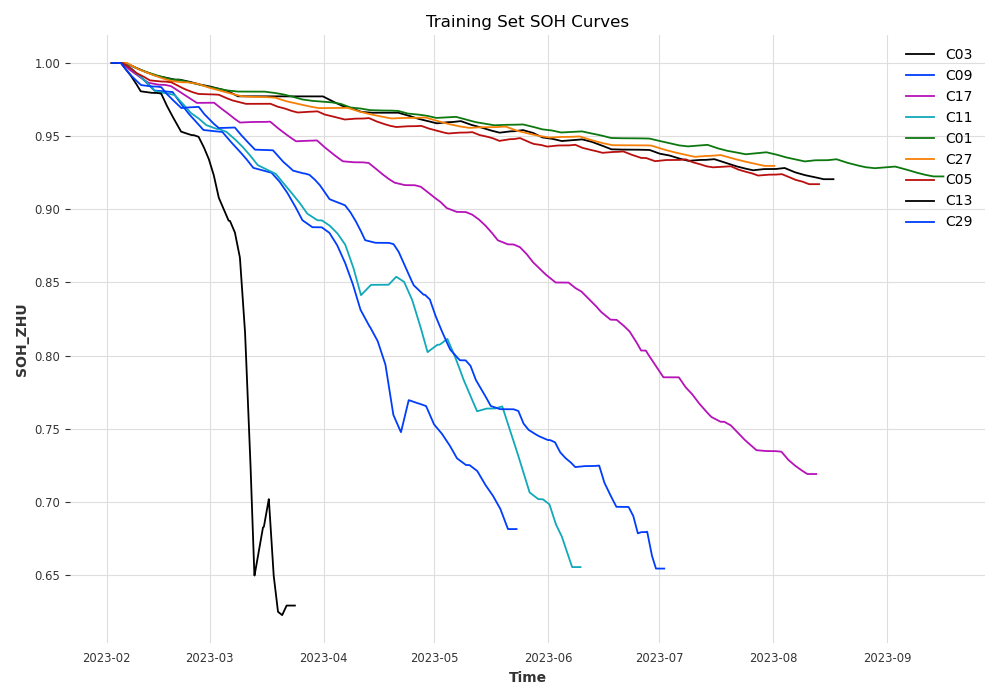

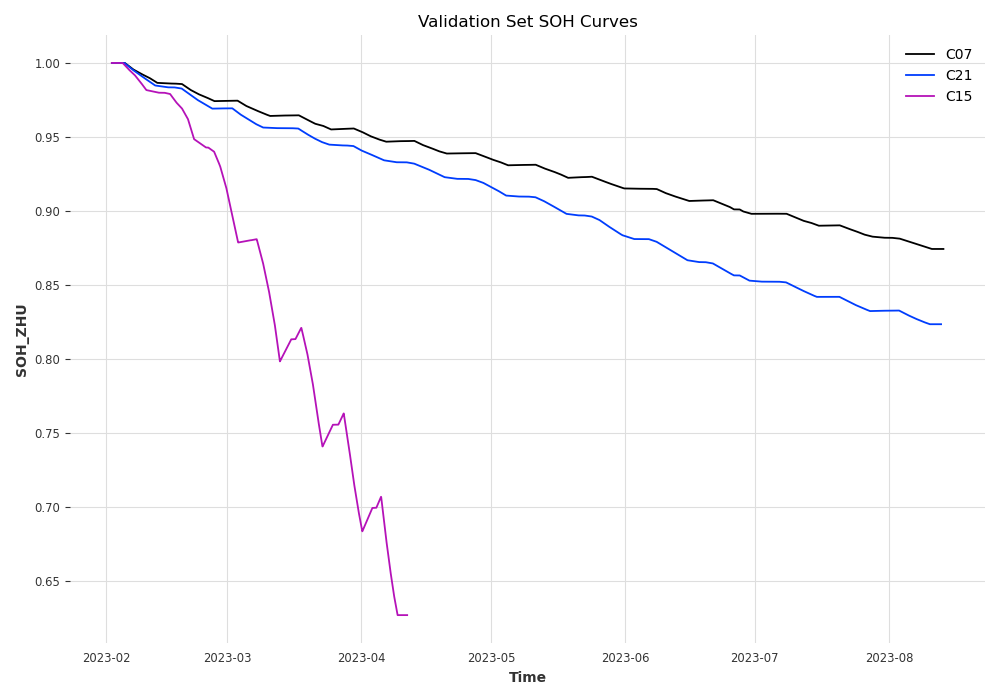

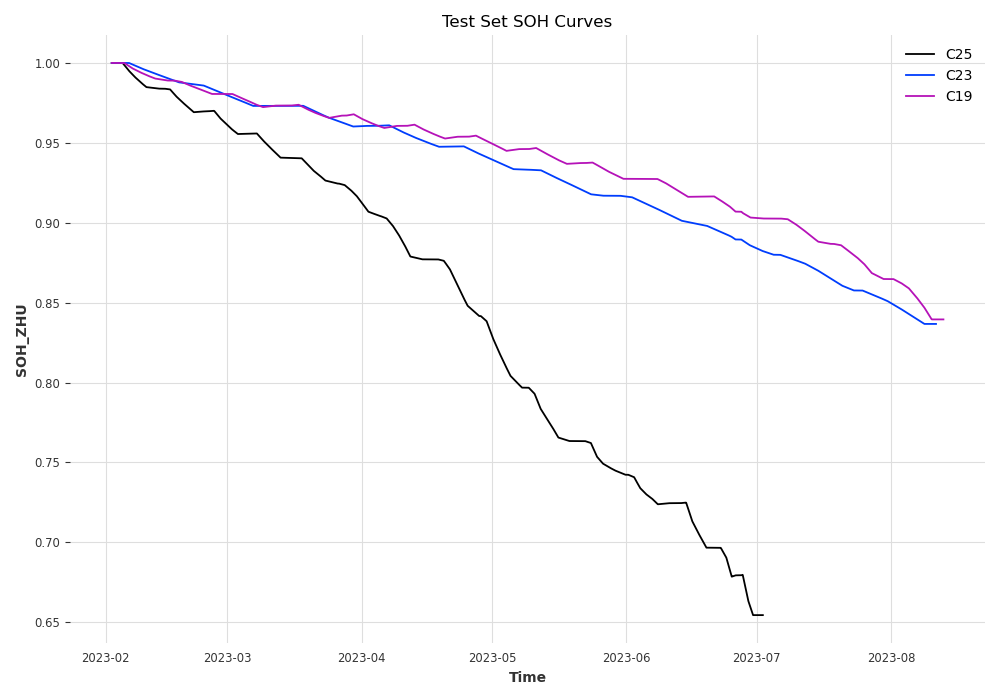

In [10]:
def plot_dataset_soh(data_dict: dict, title: str, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    
    # Plot each cell's SOH
    for cell_name, cell_data in data_dict.items():
        target = cell_data['target']
        plt.plot(target.time_index, target.values().flatten(), label=cell_name)
    
    plt.title(f'{title} Set SOH Curves')
    plt.xlabel('Time')
    plt.ylabel('SOH_ZHU')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot all three datasets
plot_dataset_soh(train_data, "Training")
plot_dataset_soh(val_data, "Validation")
plot_dataset_soh(test_data, "Test")

In [18]:
def prepare_data(train_data, val_data):
    # Concatenate training data
    train_targets = []
    train_covariates = []
    for cell_data in train_data.values():
        train_targets.append(cell_data['target'])
        train_covariates.append(cell_data['covariates_scaled'])
    
    train_series = train_targets[0]
    train_cov = train_covariates[0]
    for i in range(1, len(train_targets)):
        train_series = train_series.concatenate(train_targets[i], ignore_time_axis=True)
        train_cov = train_cov.concatenate(train_covariates[i], ignore_time_axis=True)
    
    # Concatenate validation data
    val_targets = []
    val_covariates = []
    for cell_data in val_data.values():
        val_targets.append(cell_data['target'])
        val_covariates.append(cell_data['covariates_scaled'])
    
    val_series = val_targets[0]
    val_cov = val_covariates[0]
    for i in range(1, len(val_targets)):
        val_series = val_series.concatenate(val_targets[i], ignore_time_axis=True)
        val_cov = val_cov.concatenate(val_covariates[i], ignore_time_axis=True)
    
    return train_series, train_cov, val_series, val_cov

In [ ]:
# Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    # 1. Search - Basic structure
    input_chunk_length = trial.suggest_int("input_chunk_length", 12, 24)
    output_chunk_length = trial.suggest_int("output_chunk_length", 1, 12)
    num_blocks = trial.suggest_int("num_blocks", 2, 5)
    num_stacks = trial.suggest_int("num_stacks", 2, 5)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    # 2. Search - Training parameters
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    expansion_coefficient_dim = trial.suggest_int("expansion_coefficient_dim", 5, 10)
    trend_polynomial_degree = trial.suggest_int("trend_polynomial_degree", 2, 4)

    # Define and train model
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        num_blocks=num_blocks,
        num_stacks=num_stacks,
        batch_size=batch_size,
        expansion_coefficient_dim=expansion_coefficient_dim, 
        trend_polynomial_degree=trend_polynomial_degree, 
        optimizer_kwargs={"lr": learning_rate},
        random_state=773,
        activation = activation,
        pl_trainer_kwargs={
            "callbacks": [ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)],
            "enable_checkpointing": True
        }
    )
    train_series, ctrain_cov, val_series, val_cov = prepare_data(train_data, val_data)
    
    model.fit(series=train_series, past_covariates=ctrain_cov, 
              val_series=val_series, val_past_covariates=val_cov, epochs=200)  
    
    # Retrieve best validation loss directly from the training process
    best_val_loss = model.trainer.checkpoint_callback.best_model_score.item() 
    
    return best_val_loss



In [20]:
# Optuna call with progress bar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  

# Best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-17 14:31:05,897] A new study created in memory with name: no-name-386e14fb-ab4a-4dae-99b9-1ddac65b7bdc
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory e:\00_Thesis\02_Nbeats\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.3 M  | train
-------------------------------------------------------------
2.3 M     Trainable param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2024-12-17 14:32:55,229] Trial 0 failed with parameters: {'input_chunk_length': 24, 'output_chunk_length': 1, 'num_blocks': 2, 'num_stacks': 5, 'activation': 'ReLU', 'batch_size': 16, 'learning_rate': 0.004299730172915944, 'expansion_coefficient_dim': 7, 'trend_polynomial_degree': 3} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 981, in _run
    results = self._run_stage()
  File "c:\Users\zzhuqshun\.conda\envs\ML\lib\site-pack

NameError: name 'exit' is not defined

In [10]:
best_params = {'input_chunk_length': 15, 'output_chunk_length': 1, 'batch_size': 16, 'num_blocks': 2, 'num_stacks': 2}

In [11]:
# best_params = trial.params
best_model = NBEATSModel(
    input_chunk_length=best_params["input_chunk_length"],
    output_chunk_length=best_params["output_chunk_length"],
    batch_size=best_params["batch_size"],
    num_blocks=best_params["num_blocks"],
    num_stacks=best_params["num_stacks"],
    random_state=42,
    save_checkpoints=True
)

best_model.fit(series=train_series, past_covariates=cov_train, 
               val_series=val_series, val_past_covariates=cov_val, epochs=200, verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 863 K  | train
-------------------------------------------------------------
862 K     Trainable params
1.6 K     Non-trainable params
863 K     Total params
3.455     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=2, num_blocks=2, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=15, output_chunk_length=1, batch_size=16, random_state=42, save_checkpoints=True)

c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForec

Predicting: |          | 0/? [00:00<?, ?it/s]

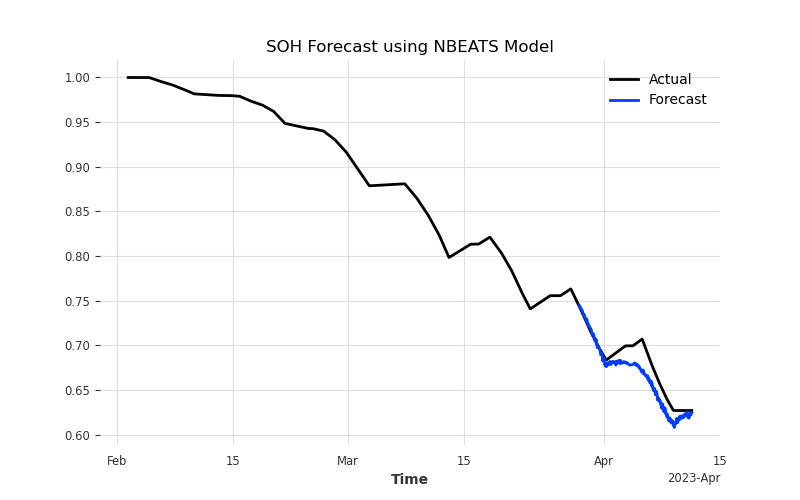

In [13]:
model = NBEATSModel.load_from_checkpoint('in22_out1_bs16_nb3_ns2')

pred_series = model.predict(len(val_series), series=train_series, past_covariates=cov_val)

plt.figure(figsize=(8, 5))
target_series.plot(label="Actual")
pred_series.plot(label="Forecast")
plt.title("SOH Forecast using NBEATS Model")
plt.xlabel("Time")
plt.legend()
plt.show()

# plt.figure(figsize=(8, 5)) 
# train_series.plot(label="train")
# val_series.plot(label="true")
# pred_series.plot(label="forecast")
# plt.legend()
# plt.xlabel('Time')
# plt.show()

In [ ]:
# param_grid = {
#     'input_chunk_length': [12, 24], # Half day or full day
#     'output_chunk_length': [1, 3, 6, 12], # One Hour or more
#     'batch_size': [16, 32, 64], # Training speed
#     'num_blocks': [2, 3], # Depth and nonliniarity
#     'num_stacks': [2, 3] # Different nonlinear mode 
# }

In [ ]:
# def grid_search_nbeats(param_grid, train_series, val_series, cov_train=None, cov_val=None):
#     best_params = None
#     best_score = float("inf")
#     best_model = None 

#     keys, values = zip(*param_grid.items())
#     param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#     for params in tqdm(param_combinations, desc="Grid Search Progress"):
#         model = NBEATSModel(
#             input_chunk_length=params['input_chunk_length'],
#             output_chunk_length=params['output_chunk_length'],
#             batch_size=params['batch_size'],
#             num_blocks=params['num_blocks'],
#             num_stacks=params['num_stacks'],
#             random_state=42
#         )

#         # Training
#         model.fit(series=train_series, past_covariates=cov_train, epochs=200)

#         # Predict
#         pred_series = model.predict(len(val_series), series=train_series, past_covariates=cov_val)
#         score = mean_absolute_error(val_series.values(), pred_series.values())

#         print(f"Params: {params} - MAE: {score}")

#         if score < best_score:
#             best_score = score
#             best_params = params
#             best_model = model
#     if best_model is not None:
#         best_model.save_model("best_nbeats_model.pth")
#         print("Best model saved as 'best_nbeats_model.pth'")
        
#     print(f"Best Params: {best_params} with MAE: {best_score}")
#     return best_params, best_score

# best_params, best_score = grid_search_nbeats(param_grid, train_series, val_series, cov_train=cov_train, cov_val=cov_val)
